## Word embeddings

Embedding Projector: http://projector.tensorflow.org/

In [ ]:
import io 
import os
import re
import shutil
import string
import numpy as np
import tensorflow as tf

## Representing text as numbers
Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, you will look at three strategies for doing so.

### One-hot encodings:

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

![one-hot](./one-hot.png)

To create a vector that contains the encoding of the sentence, you could then concatenate the one-hot vectors for each word.

### Encode each word with a unique number:

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

There are two downsides to this approach, however:

- The integer-encoding is arbitrary (it does not capture any relationship between words).

- An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings:

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

![embedding2](./embedding2.png)

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = 1000,output_dim = 64,input_length = 10))
'''
The model will take as input an iterger matrix of size (batch,input_length),and the largest integer (i.e word index)
in the input. should be no larger than 999 (vocabulary size).
Now model.output_shape is (None,10,64), where `None` is the batch dimension
input_dim : Integer, size of vocabulary, i.e maximum is interger index +1 
output_dim : Integer, Dimension of dense embedding
input_length: Length of input sequences, when it is constant. This argument is required i
f you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).

'''
input_array = np.random.randint(1000,size = (32,10)) # (sample_number,input_length)
print(f"input_array: {input_array.shape}")
model.compile('rmsprop','mse')
output_array = model.predict(input_array)
print(f"output_array: {output_array.shape}")

input_array: (32, 10)
output_array: (32, 10, 64)


## Download the IMDb Dataset

You will use the [Large Movie Review](http://ai.stanford.edu/~amaas/data/sentiment/) Dataset through the tutorial. You will train a sentiment classifier model on this dataset and in the process learn embeddings from scratch. To read more about loading a dataset from scratch, see the [Loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text).

Download the dataset using Keras file utility and take a look at the directories.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz",
                                  url,
                                  untar = True,
                                  cache_dir = '.',
                                  cache_subdir = ''
                                 )

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')
os.listdir(dataset_dir)

84140032/84125825 [==============================] - 606s 7us/step


['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

Take a look at the `train/` directory. It has `pos` and `neg` folders with movie reviews labelled as positive and negative respectively. You will use reviews from `pos` and `neg` folders to train a binary classification model.

In [31]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

The `train` directory also has additional folders which should be removed before creating training dataset.

In [33]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

Next, create a `tf.data.Dataset` using `tf.keras.utils.text_dataset_from_directory`. You can read more about using this utility in this [text classification tutorial](https://www.tensorflow.org/tutorials/keras/text_classification).

Use the train directory to create both train and validation datasets with a split of 20% for validation.

In [35]:
batch_size = 1024
seed = 123
# train
train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                       batch_size = batch_size,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       seed = seed
                                                        )

val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                       batch_size = batch_size,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = seed
                                                        )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Take a look at a few movie reviews and their labels `(1: positive, 0: negative)` from the train dataset.

In [42]:
for text_batch,label_batch in train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy()," : ",text_batch.numpy()[i])
        print("\n")

0  :  b"Wow. Some movies just leave me speechless. This was undeniably one of those movies. When I left the theatre, not a single word came to my mouth. All I had was an incredible urge to slam my head against the theatre wall to help me forget about the last hour and a half. Unfortunately, it didn't work. Honestly, this movie has nothing to recommend. The humor was at the first grade level, at best, the acting was overly silly, and the plot was astronomically far-fetched. I hearby pledge never to see an other movie starring Chris Kattan or any other cast-member of SNL."


1  :  b'If any show in the last ten years deserves a 10, it is this rare gem. It allows us to escape back to a time when things were simpler and more fun. Filled with heart and laughs, this show keeps you laughing through the three decades of difference. The furniture was ugly, the clothes were colorful, and the even the drugs were tolerable. The hair was feathered, the music was accompanied by roller-skates, and in 

## Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [43]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## Using the Embedding layer

Keras makes it easy to use word embeddings. Take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [38]:
# Embed a 1000 word vocabulary into 5 dimensions
embedding_layer = tf.keras.layers.Embedding(1000,5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [39]:
# width = np.random.randint(10)
# input = np.random.rand(width)
result = embedding_layer(tf.constant([1,2,3]))
print(result.shape)
result.numpy()

(3, 5)


array([[ 0.03370622, -0.04908353, -0.0200971 , -0.0451408 , -0.01668329],
       [ 0.01682807, -0.01845165, -0.01166041, -0.00564532,  0.04736647],
       [ 0.02346439, -0.04127623, -0.00068667,  0.04478325, -0.00877509]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`

In [40]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
print(result.shape)
print(result)

(2, 3, 5)
tf.Tensor(
[[[-0.02427975  0.01467308  0.00526615 -0.00207376  0.00761747]
  [ 0.03370622 -0.04908353 -0.0200971  -0.0451408  -0.01668329]
  [ 0.01682807 -0.01845165 -0.01166041 -0.00564532  0.04736647]]

 [[ 0.02346439 -0.04127623 -0.00068667  0.04478325 -0.00877509]
  [ 0.04794813 -0.00600418  0.03465143 -0.03749007 -0.04010221]
  [-0.01621849 -0.02563468 -0.03893682 -0.00997553 -0.03375311]]], shape=(2, 3, 5), dtype=float32)


When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's the simplest. [The Text Classification with an RNN tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn) is a good next step.

In [127]:
# Create a custom standardization function to strip HTML break tags '<br />'
def custom_standardization(input_data):
    lowercase = tf.string.lower(input_data)
    stripped_html = tf.string.regex_replace(lowercase, '<br />',' ')
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

# Vocabulary size and number of words in a sequence
vocab_size = 10000
sequence_length = 100

text_ds = train_ds.map(lambda x,y:x)
for i in text_ds.take(1):
    print(i)

tf.Tensor(
[b"If you want an undemanding and reasonably amusing hour or so, then it's OK to watch this. It's not all that bad, really. Yeah, it's got more lapses in logic than I care to describe here and might tax the patience of people - like myself, I have to admit - who are inclined to throw things at the TV on occasion, but it's funny at least. Just because it's not always INTENTIONALLY funny, there's no need to let that get you down.<br /><br />However, if you've read the book - or any of the other books by Brookmyre - then you'd probably best avoid it. I've read them all and when I first watched this film, I despised it. I've trashed it in detail and at great length on another site, in fact. The TV plot bears practically no relevance at all to that of the book and served only to outrage and infuriate many faithful (and admittedly rabid) Brookmyre fans.<br /><br />Best bit of advice..? Watch this, then read the book and only THEN make your comparisons and submit your judgement."
 

In [128]:
vocab_data = []
print(f"shape of data {i.shape}")
for j in range(i.shape[0]):
    vocab_data += i.numpy()[j].split()
print(len(vocab_data))
print(vocab_data[0])

shape of data (1024,)
237551
b'If'


In [129]:
vocab_data_str = [x.decode('utf-8') for x in vocab_data]
vocab_data_decode = []
for  text in vocab_data_str:
    if text not in vocab_data_decode:
        vocab_data_decode.append(text)

In [130]:
len(vocab_data_decode)

35108

In [131]:
'''
Use the text vectorization layer to normalize, split, and map strings to integers
Note that the layer uses the custom standardization defined above,
Set maximum_sequence length as all samples are not of the same length
'''
vectorize_layer = tf.keras.layers.TextVectorization(#standardize=custom_standardization,
                                                    max_tokens=len(vocab_data_decode)+2, # Passed vocab size is 35960, max vocab size is 35958?
                                                    output_mode='int',
                                                    output_sequence_length=sequence_length,
                                                    vocabulary = vocab_data_decode                                                       
)

## TextVectorization

    
    tf.keras.layers.TextVectorization(
        max_tokens=None,
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        ngrams=None,
        output_mode='int',
        output_sequence_length=None,
        pad_to_max_tokens=False,
        vocabulary=None,
        idf_weights=None,
        sparse=False,
        ragged=False,
        **kwargs
    )


In [63]:
text_dataset = tf.data.Dataset.from_tensor_slices(['foo','bar','baz'])
# Create the layer
vectorize_layer = tf.keras.layers.TextVectorization(
max_tokens = max_features,
output_mode  = 'int',
output_sequence_length = max_len
)
'''
Now that the vocab layer has been created, call adapt on the text-only dataset to create the vocabulary,
You don't have to batch, but for large datasets this mean are keeping spare copies of the dataset.
'''
vectorize_layer.adapt(text_dataset.batch(64))
# Create the model that uses the vectorize text layer
model = tf.keras.models.Sequential()
'''
Start by creating an explicit input layer, it needs to have a shape of (1,), because we need to guarantee that there is 
exactly one string input per batch and the dtype needs to be string
'''
model.add(tf.keras.Input(shape = (1,),dtype = tf.string))
'''
The first layer in our model is vectorization layer, After this layer, we have a tensor of shape (batch_size, max_len) containing
vocab indices
'''
model.add(vectorize_layer)
'''
Now let the model can map string to intergers, and you can add an embedding layer to map these integers to learned embeddings
'''
input_data =[['foo qux bar'],['qux bar']]
model.predict(input_data)


array([[2, 1, 4, 0],
       [1, 4, 0, 0]], dtype=int64)

In [124]:
'''
This example instantiates TextVectorization layer by passing a list of vocabulary term to layer method
'''
vocab_data = ['earth','wind','and','fire']
max_features = 5000 # Maximum vocab size
max_len = 4 # Sequence length to pad the output to
'''
Create the layer, passing the vocab directly, You can also pass the vocabulary arg a path to a file containing one vocabulary word per line
'''
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = max_features,
                                                    output_mode = 'int',
                                                    output_sequence_length = max_len,
                                                    vocabulary = vocab_data
)
'''
Because we are passed the vocabulary directly, we dont need to adapt the layer - the vocabulary is already set,
The vocabulary contains the padding token ('') and OOV token (['UNK']) as well as  the passed tokens
'''
vectorize_layer.get_vocabulary()

['', '[UNK]', 'earth', 'wind', 'and', 'fire']

## Create a classification model
Use the Keras Sequential API to define the sentiment classification model. In this case it is a "Continuous bag of words" style model.

- The TextVectorization layer transforms strings into vocabulary indices. You have already initialized vectorize_layer as a TextVectorization layer and built its vocabulary by calling adapt on text_ds. Now vectorize_layer can be used as the first layer of your end-to-end classification model, feeding transformed strings into the Embedding layer.

- The Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

- The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

- The fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

- The last layer is densely connected with a single output node.

In [133]:
embedding_dim = 16

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(len(vocab_data_decode)+2,embedding_dim,name = 'embedding'),
    tf.keras.layers.AveragePooling1D(),
    tf.keras.layers.Dense(16,activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [137]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = ['accuracy'])

In [138]:
# Create tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

In [140]:
history = model.fit(train_ds,
         validation_data = val_ds,
         epochs = 15,
         callbacks = [tensorboard_callback])

Epoch 1/15
20/20 [==============================] - 96s 5s/step - loss: 1.6066 - accuracy: 0.5028 - val_loss: 1.3084 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 7s 353ms/step - loss: 1.2004 - accuracy: 0.5028 - val_loss: 1.1573 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 7s 354ms/step - loss: 1.0828 - accuracy: 0.5028 - val_loss: 1.0573 - val_accuracy: 0.4886
Epoch 4/15
20/20 [==============================] - 7s 365ms/step - loss: 0.9950 - accuracy: 0.5028 - val_loss: 0.9752 - val_accuracy: 0.4886
Epoch 5/15
20/20 [==============================] - 7s 362ms/step - loss: 0.9218 - accuracy: 0.5028 - val_loss: 0.9059 - val_accuracy: 0.4886
Epoch 6/15
20/20 [==============================] - 7s 368ms/step - loss: 0.8606 - accuracy: 0.5028 - val_loss: 0.8486 - val_accuracy: 0.4886
Epoch 7/15
20/20 [==============================] - 7s 358ms/step - loss: 0.8107 - accuracy: 0.5028 - val_loss: 0.8025 - val_accuracy: 0.4886
Epoch 8/

In [141]:
# summary your model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_37 (TextV (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           561760    
_________________________________________________________________
average_pooling1d_1 (Average (None, 50, 16)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 50, 16)            272       
_________________________________________________________________
dense_3 (Dense)              (None, 50, 1)             17        
Total params: 562,049
Trainable params: 562,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# View tensorboard callback on google colab
%load_ext tensorboard
%tensorboard --logdir logs

In [142]:
import helper_functions as hp

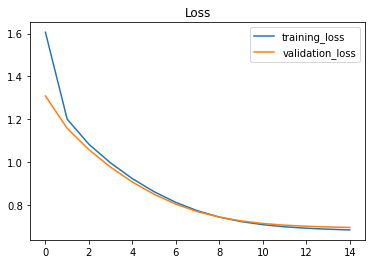

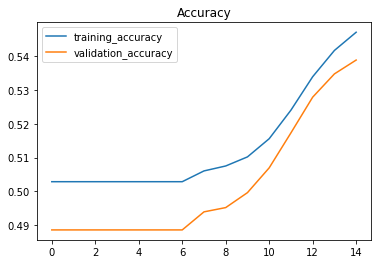

In [143]:
hp.plot_loss_curves(history)

## Retrieve the trained word embeddings and save them to disk
Next, retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape `(vocab_size, embedding_dimension)`.

Obtain the weights from the model using `get_layer()` and `get_weights()`. The get_vocabulary() function provides the vocabulary to build a metadata file with one token per line.

In [146]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

Write the weights to disk. To use the Embedding Projector, you will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [150]:
out_v = io.open('vectors.tsv','w',encoding = 'utf-8')
out_m = io.open('metadata.tsv','w',encoding = 'utf-8')
for index,word in enumerate(vocab):
    if index == 0:
        continue # skip 0, it's padding
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + '\n')
out_v.close()
out_m.close()

## Visualize the embeddings
To visualize the embeddings, upload them to the embedding projector.

Open the Embedding Projector (this can also run in a local TensorBoard instance).

Click on "Load data".

Upload the two files you created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".

## Reference

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

https://www.tensorflow.org/tutorials/load_data/text

https://www.tensorflow.org/tutorials/keras/text_classification

https://www.tensorflow.org/text/tutorials/text_classification_rnn